# Clustering solutions using LDA #

In [89]:
# Input
from db import PythonProblems
import io

# Helpers
import numpy as np
from collections import Counter
from tqdm import tqdm
import random

# Preprocessing
import tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Learning
from sklearn.decomposition import LatentDirichletAllocation

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import show, output_notebook
from bokeh.plotting import figure

### Connecting to database

In [90]:
db = PythonProblems('python.sqlite')

In [91]:
removed_itens = ['NEWLINE', 'STRING', 'ENDMARKER', 'NUMBER', 'INDENT', 'DEDENT', "NL", 'COMMENT', 'ERRORTOKEN']
allowed_itens = ['NAME', 'OP']
cursor = db.conn.cursor()
docs = []
errors = []

# lendo os dados
cursor.execute("""
SELECT * FROM solution;
""")


for idx, linha in enumerate(cursor.fetchall()):
    file = io.StringIO(linha[1])
    doc = []
    try:
        for item in tokenize.generate_tokens(file.readline):
            if tokenize.tok_name[item[0]] not in removed_itens:
                if tokenize.tok_name[item[0]] in allowed_itens:
                    doc.append(item[1])
                else:
                    print("%s %s" % (tokenize.tok_name[item[0]], item[1]))
    except (IndentationError, tokenize.TokenError):
        errors.append("Please, fix solution %d before continuing" % (idx+1))
        
    docs.append(' '.join(doc))

print("Got %d documents" %(idx+1))

if not errors:
    print("Success in parsing all documents! You may go on!")
else:
    for item in errors:
        print(item)

Got 758 documents
Success in parsing all documents! You may go on!


### Preprocessing solutions into bag of words ###

In [103]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
# vectorizer = TfidfVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = ['print'],   \
                             #max_features = 26d,
                             binary=False,
                             min_df=0.1
                            ) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features = vectorizer.fit_transform(docs)

# Numpy arrays are easy to work with, so convert the result to an 
# array
# Document-term matrix
#train_data_features = train_data_features.toarray()
train_data_features.shape

(758, 15)

# Cálculo da LDA #

### Cálculo dos modelos e da métrica *perplexity* ###

In [93]:
num_topics = list(range(2, 100))

In [94]:
output_notebook()

hover = HoverTool(tooltips=[
    ("Model", "$x{0}"),
    ("Perplexity", "$y"),
])


models = {}
x_values = []
y_values = []

for k in tqdm(num_topics):
    # Build a Latent Dirichlet Allocation Model
    model = LatentDirichletAllocation(n_components=k, max_iter=10, learning_method='batch')
    document_topic = model.fit_transform(train_data_features)
    models[k] = {
      'model': model,
      'topic_word': model.components_,
      'document_topic': document_topic,
      'perplexity': model.perplexity(train_data_features)
    }

    x_values.append(k)
    y_values.append(models[k]["perplexity"])

source = {'x_values': x_values, 'y_values': y_values}

opts = dict(plot_width=900, plot_height=500, min_border=0, title="Perplexity")
plot = figure(**opts)
plot.add_tools(hover)

l = plot.line(x='x_values', y='y_values', color="#2222aa", line_width=2, source=source)
c = plot.circle(x='x_values', y='y_values', color="#2222aa", fill_color="white", size=8, source=source)
h = show(plot, notebook_handle=True)

Loading BokehJS ...

100%|██████████| 98/98 [04:00<00:00,  2.73s/it]


### Verificando em * random sample solutions* ###

In [104]:
# Escolhido tópico k
k = 4
lda_model = models[k]['model']
document_topic = models[k]['document_topic']
topic_word = models[k]['topic_word']

In [105]:
# Verificando 5 soluções de maneira aleatória
N = 5

cursor.execute("""
SELECT * FROM solution;
""")

solutions = list(cursor.fetchall())
random.shuffle(list(range(len(solutions))))

for i in range(N):
    text = solutions[i][1]
    x = lda_model.transform(vectorizer.transform([text]))[0]
    print(text)
    #print(x)
    print("Belong to topics with probabilities:")
    topics = np.argsort(x)[:-6:-1]
    probs = x[topics]
    print("t: %s" %(topics+1))
    print("P(t|d): %s" %probs)

    print('\n')

name = input("What is your name: ")
age = int(input("How old are you: "))
year = str((2014 - age)+100)
print(name + " will be 100 years old in the year " + year)

Belong to topics with probabilities:
t: [3 4 1 2]
P(t|d): [0.65295951 0.24703457 0.05000422 0.05000171]


num = input("Enter a number: ")
mod = num % 2
if mod > 0:
    print("You picked an odd number.")
else:
    print("You picked an even number.")
Belong to topics with probabilities:
t: [3 1 4 2]
P(t|d): [0.80859196 0.06519802 0.06370337 0.06250665]


num = int(input("give me a number to check: "))
check = int(input("give me a number to divide by: "))

if num % 4 == 0:
    print(num, "is a multiple of 4")
elif num % 2 == 0:
    print(num, "is an even number")
else:
    print(num, "is an odd number")

if num % check == 0:
    print(num, "divides evenly by", check)
else:
    print(num, "does not divide evenly by", check)

Belong to topics with probabilities:
t: [3 1 4 2]
P(t|d): [0.92405559 0.02564561 0.02529692 0.02500188]




In [106]:
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, train_data_features, vectorizer, mds='tsne', sort_topics=False)
panel

/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics          x           y
topic                                                   
0      24.673650        1       1  81.155663 -172.464539
1       7.111127        1       2   9.373425 -138.256073
2      31.078900        1       3  46.945957 -244.246140
3      37.136323        1       4 -24.836102 -210.037704, topic_info=     Category        Freq    Term       Total  loglift  logprob
term                                                           
7     Default  298.000000  import  298.000000  15.0000  15.0000
1     Default  368.000000     def  368.000000  14.0000  14.0000
8     Default  526.000000      in  526.000000  13.0000  13.0000
13    Default  335.000000  return  335.000000  12.0000  12.0000
4     Default  450.000000     for  450.000000  11.0000  11.0000
9     Default  310.000000   input  310.000000  10.0000  10.0000
12    Default  232.000000   range  232.000000   9.0000   9.0000
10    Default  202.000000     int  202.000000   8.0000   8.0000
5     Default  187.000000  format  187.000000   7.0000   7.0000
2     Default  226.000000    elif  226.000000   6.0000   6.0000
0     Default  120.000000  append  120.000000   5.0000   5.0000
6     Default  490.000000      if  490.000000   4.0000   4.0000
3     Default  233.000000    else  233.000000   3.0000   3.0000
14    Default  110.000000   while  110.000000   2.0000   2.0000
11    Default  152.000000     len  152.000000   1.0000   1.0000
13     Topic1  334.333819  return  335.248229   1.3967  -1.1422
1      Topic1  366.166272     def  368.404493   1.3933  -1.0512
14     Topic1   50.642480   while  110.853831   0.6160  -3.0295
6      Topic1  168.079060      if  490.891714   0.3276  -1.8299
11     Topic1   45.333364     len  152.197882   0.1883  -3.1403
3      Topic1   58.294276    else  233.745795   0.0107  -2.8888
2      Topic1   15.551146    elif  226.651661  -1.2798  -4.2102
0      Topic1    6.563548  append  120.482077  -1.5105  -5.0728
10     Topic1    0.956632     int  202.526286  -3.9558  -6.9986
5      Topic1    0.256807  format  187.606406  -5.1943  -8.3137
9      Topic1    0.379335   input  310.322334  -5.3075  -7.9236
12     Topic1    0.273803   range  232.392204  -5.3443  -8.2496
7      Topic1    0.256913  import  298.142002  -5.6572  -8.3133
4      Topic1    0.282353     for  450.306626  -5.9751  -8.2189
8      Topic1    0.273387      in  526.228461  -6.1632  -8.2512
...       ...         ...     ...         ...      ...      ...
9      Topic3  309.381092   input  310.322334   1.1656  -1.4505
5      Topic3  186.796964  format  187.606406   1.1643  -1.9551
10     Topic3  199.725310     int  202.526286   1.1547  -1.8881
2      Topic3  210.554289    elif  226.651661   1.0950  -1.8353
3      Topic3  142.314809    else  233.745795   0.6724  -2.2271
14     Topic3   49.986585   while  110.853831   0.3722  -3.2733
6      Topic3  180.931688      if  490.891714   0.1705  -1.9870
11     Topic3   32.855267     len  152.197882  -0.3644  -3.6930
0      Topic3    3.284589  append  120.482077  -2.4336  -5.9959
8      Topic3    2.500756      in  526.228461  -4.1805  -6.2685
12     Topic3    0.256793   range  232.392204  -5.6393  -8.5446
7      Topic3    0.254962  import  298.142002  -5.8956  -8.5517
13     Topic3    0.252338  return  335.248229  -6.0232  -8.5621
1      Topic3    0.255132     def  368.404493  -6.1065  -8.5511
4      Topic3    0.259516     for  450.306626  -6.2902  -8.5340
4      Topic4  449.459961     for  450.306626   0.9887  -1.2551
12     Topic4  231.560236   range  232.392204   0.9870  -1.9183
8      Topic4  523.150278      in  526.228461   0.9847  -1.1033
0      Topic4  110.331989  append  120.482077   0.9026  -2.6597
11     Topic4   73.707753     len  152.197882   0.2655  -3.0631
6      Topic4  141.311779      if  490.891714  -0.2547  -2.4122
3      Topic4   32.779025    else  233.745795  -0.9739  -3.8734
14     Topic4    9.919897   while  110.853831  -1.4231  -5.0686
10     Topic4    1.543074     i

#### Verificando distribuição de documentos por tópico ####

In [107]:
row_sums = document_topic.sum(axis=1)
document_topic_norm = document_topic / row_sums[:, np.newaxis]
document_topic_norm.shape

(758, 4)

Considerando somente pertinência máxima

In [108]:
Counter(np.argmax(document_topic, axis=1))

Counter({0: 244, 1: 111, 2: 152, 3: 251})

Considerando probabilidade

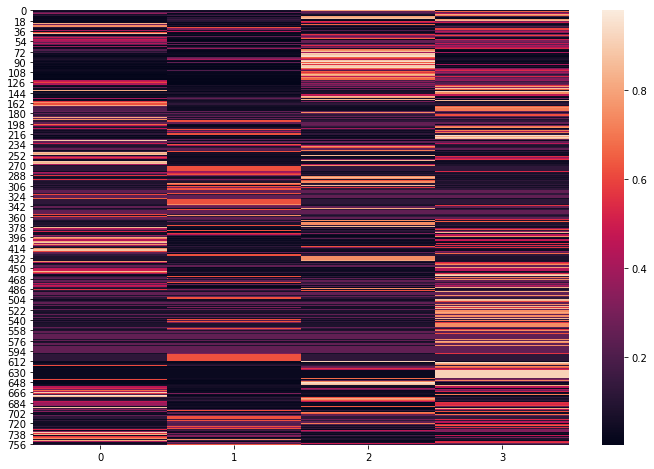

In [109]:
fig = plt.figure(figsize=(12,8))
ax = sns.heatmap(document_topic_norm)
plt.show()

In [110]:
def print_top_words(topic_word, feature_names, n_top_words):
    for topic_idx, topic in enumerate(topic_word):
        message = "Topic #%d: " % (topic_idx+1)
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [112]:
print("\nTopics in LDA model:")
feature_names = vectorizer.get_feature_names()
print_top_words(topic_word, feature_names, 5)


Topics in LDA model:
Topic #1: def return if else while
Topic #2: import if else format while
Topic #3: input elif int format if
Topic #4: in for range if append

